# Nb-20180314-1549-RandomForest-GainPrediction

In [1]:
STAMP = "20180314-1549"

This is a modification of the previous notebook.

Do a simple random forest to try to predict if a stock sticker will make a gain the next day.


Add in standard MACD + Bollinger Bands.

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from collections import defaultdict
import operator

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [5]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [6]:
import finance as fat

In [7]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [8]:
ticker = 'IBM'

In [9]:
raw = fat.get_price_data(ticker)
ohlcv = raw

Loaded data for IBM: 1970-01-02 to 2018-03-12.


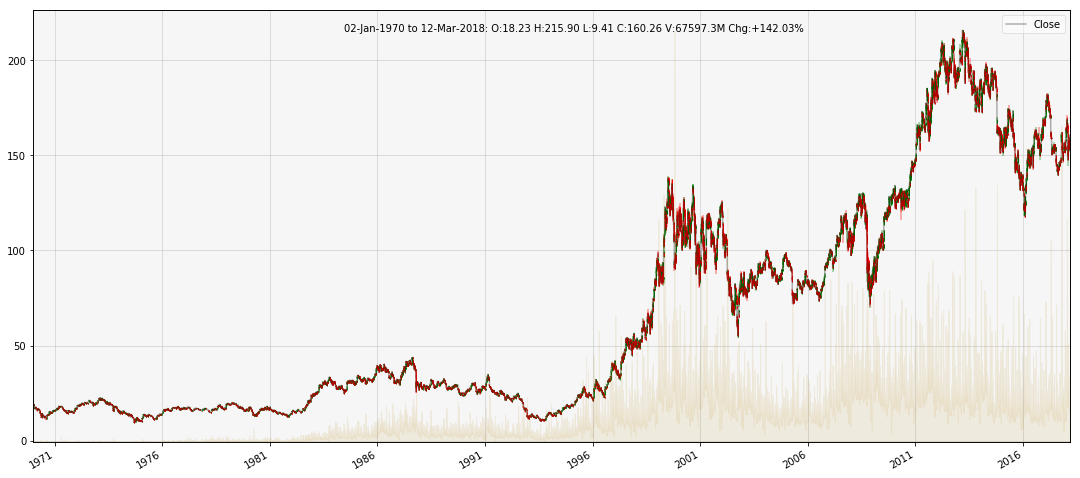

In [10]:
fat.plot_daily_ticker(ohlcv)

In [10]:
raw.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,18.225000,18.287500,18.200001,18.237499,1.689605,315200
1970-01-05,18.299999,18.412500,18.299999,18.412500,1.705818,424000
1970-01-06,18.412500,18.450001,18.312500,18.424999,1.706977,488000
1970-01-07,18.424999,18.437500,18.312500,18.437500,1.708133,457600
1970-01-08,18.437500,18.475000,18.375000,18.475000,1.711608,707200


### Price and Created Features

Scale the OHLC data to match 'Adj Close'

In [11]:
data = raw.copy()
data = data.div((data['Close']/data['Adj Close']), axis=0)
del data['Adj Close']
del data['Volume']
data.head()

,Open,High,Low,Close
Date,,,,
1970-01-02,1.688447,1.694237,1.686131,1.689605
1970-01-05,1.695395,1.705818,1.695395,1.705818
1970-01-06,1.705819,1.709293,1.696555,1.706977
1970-01-07,1.706975,1.708133,1.696552,1.708133
1970-01-08,1.708134,1.711608,1.702344,1.711608


Get table with prices for last 5 days, and price for following day.

In [12]:
for i in range(-5, 0, 1) :
    data[f'Close {i}d'] = data['Close'].shift(-i)
data = data.dropna()
data.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d
Date,,,,,,,,,
1970-01-09,1.711607,1.716239,1.706975,1.709291,1.689605,1.705818,1.706977,1.708133,1.711608
1970-01-12,1.709292,1.712766,1.703502,1.703502,1.705818,1.706977,1.708133,1.711608,1.709291
1970-01-13,1.703502,1.741717,1.703502,1.733032,1.706977,1.708133,1.711608,1.709291,1.703502
1970-01-14,1.733032,1.739401,1.727821,1.731295,1.708133,1.711608,1.709291,1.703502,1.733032
1970-01-15,1.737085,1.767195,1.737085,1.767195,1.711608,1.709291,1.703502,1.733032,1.731295


In [13]:
data = fat.add_bollinger_bands(data, 'Close')

In [14]:
data = fat.add_sma_columns(data, 'Close', [6,12,200])

In [15]:
data = fat.add_ema_columns(data, 'Close', [3, 6, 50])

In [16]:
scaled = data.div(data['Close'], axis=0)
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA20,Close BBandHi20,Close BBandLo20,Close SMA6,Close SMA12,Close SMA200,Close EMA3,Close EMA6,Close EMA50
Date,,,,,,,,,,,,,,,,,,
1970-01-09,1.001355,1.004065,0.998645,1.0,0.988483,0.997968,0.998646,0.999323,1.001356,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000
1970-01-12,1.003399,1.005438,1.000000,1.0,1.001360,1.002040,1.002719,1.004758,1.003398,NaN,NaN,NaN,NaN,NaN,NaN,1.001133,1.001416,1.001665
1970-01-13,0.982960,1.005012,0.982960,1.0,0.984966,0.985633,0.987638,0.986301,0.982960,NaN,NaN,NaN,NaN,NaN,NaN,0.993175,0.991387,0.989938
1970-01-14,1.001003,1.004682,0.997993,1.0,0.986622,0.988629,0.987290,0.983947,1.001003,NaN,NaN,NaN,NaN,NaN,NaN,0.997280,0.995324,0.993336
1970-01-15,0.982962,1.000000,0.982962,1.0,0.968545,0.967234,0.963958,0.980668,0.979685,NaN,NaN,NaN,NaN,NaN,NaN,0.988881,0.983842,0.978964


In [17]:
scaled = scaled.dropna()
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA20,Close BBandHi20,Close BBandLo20,Close SMA6,Close SMA12,Close SMA200,Close EMA3,Close EMA6,Close EMA50
Date,,,,,,,,,,,,,,,,,,
1970-10-21,1.007789,1.022934,0.999567,1.0,1.009087,1.014279,1.006491,0.984855,1.007789,1.018217,1.062547,0.973888,1.003750,1.018102,1.010789,1.001286,1.004593,0.969068
1970-10-22,1.003038,1.005208,0.993924,1.0,1.017361,1.009549,0.987847,1.010850,1.003038,1.021224,1.065856,0.976592,1.004774,1.015661,1.012510,1.002164,1.005461,0.973110
1970-10-23,0.978814,1.000847,0.978814,1.0,0.985593,0.964406,0.986864,0.979237,0.976271,0.998093,1.040745,0.955441,0.982062,0.988524,0.987305,0.989192,0.986858,0.951979
1970-10-26,1.017256,1.017256,0.997412,1.0,0.981881,1.004745,0.996980,0.993960,1.018119,1.016134,1.059625,0.972644,0.999281,1.003990,1.003795,1.003558,1.003385,0.970436
1970-10-27,0.995704,1.000000,0.993127,1.0,1.000429,0.992698,0.989691,1.013746,0.995705,1.011641,1.055075,0.968207,0.998712,0.998210,0.998118,0.999624,0.999340,0.967591


In [18]:
del scaled['Close']
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA20,Close BBandHi20,Close BBandLo20,Close SMA6,Close SMA12,Close SMA200,Close EMA3,Close EMA6,Close EMA50
Date,,,,,,,,,,,,,,,,,
1970-10-21,1.007789,1.022934,0.999567,1.009087,1.014279,1.006491,0.984855,1.007789,1.018217,1.062547,0.973888,1.003750,1.018102,1.010789,1.001286,1.004593,0.969068
1970-10-22,1.003038,1.005208,0.993924,1.017361,1.009549,0.987847,1.010850,1.003038,1.021224,1.065856,0.976592,1.004774,1.015661,1.012510,1.002164,1.005461,0.973110
1970-10-23,0.978814,1.000847,0.978814,0.985593,0.964406,0.986864,0.979237,0.976271,0.998093,1.040745,0.955441,0.982062,0.988524,0.987305,0.989192,0.986858,0.951979
1970-10-26,1.017256,1.017256,0.997412,0.981881,1.004745,0.996980,0.993960,1.018119,1.016134,1.059625,0.972644,0.999281,1.003990,1.003795,1.003558,1.003385,0.970436
1970-10-27,0.995704,1.000000,0.993127,1.000429,0.992698,0.989691,1.013746,0.995705,1.011641,1.055075,0.968207,0.998712,0.998210,0.998118,0.999624,0.999340,0.967591


### Volume and Created Features

In [19]:
vol = pd.DataFrame(raw, columns=['Volume'])
vol.head()

,Volume
Date,
1970-01-02,315200
1970-01-05,424000
1970-01-06,488000
1970-01-07,457600
1970-01-08,707200


In [20]:
# replace 0's, since they cause potential blow-ups
vol = vol.replace(0, 1)
vol.describe()

,Volume
count,1.215800e+04
mean,5.559903e+06
std,4.521317e+06
min,1.000000e+00
25%,2.415975e+06
50%,4.801200e+06
75%,7.404975e+06
max,6.944470e+07


In [21]:
for i in range(-5, 0, 1) :
    vol[f'Volume {i}d'] = vol['Volume'].shift(-i)
vol = vol.dropna()
vol.head()

,Volume,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,,
1970-01-09,585600,315200.0,424000.0,488000.0,457600.0,707200.0
1970-01-12,379200,424000.0,488000.0,457600.0,707200.0,585600.0
1970-01-13,744000,488000.0,457600.0,707200.0,585600.0,379200.0
1970-01-14,392000,457600.0,707200.0,585600.0,379200.0,744000.0
1970-01-15,420800,707200.0,585600.0,379200.0,744000.0,392000.0


In [22]:
vol = vol.div(vol['Volume'], axis=0)
vol.head()

,Volume,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,,
1970-01-09,1.0,0.538251,0.724044,0.833333,0.781421,1.207650
1970-01-12,1.0,1.118143,1.286920,1.206751,1.864979,1.544304
1970-01-13,1.0,0.655914,0.615054,0.950538,0.787097,0.509677
1970-01-14,1.0,1.167347,1.804082,1.493878,0.967347,1.897959
1970-01-15,1.0,1.680608,1.391635,0.901141,1.768061,0.931559


In [23]:
del vol['Volume']
vol.head()

,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,
1970-01-09,0.538251,0.724044,0.833333,0.781421,1.207650
1970-01-12,1.118143,1.286920,1.206751,1.864979,1.544304
1970-01-13,0.655914,0.615054,0.950538,0.787097,0.509677
1970-01-14,1.167347,1.804082,1.493878,0.967347,1.897959
1970-01-15,1.680608,1.391635,0.901141,1.768061,0.931559


In [24]:
vol.describe()

,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
count,1.215300e+04,1.215300e+04,1.215300e+04,1.215300e+04,1.215300e+04
mean,2.835225e+02,5.300415e+02,5.406329e+02,4.159110e+02,3.990648e+02
std,1.875804e+04,3.557069e+04,3.972874e+04,2.877679e+04,2.986084e+04
min,1.634949e-07,2.906301e-07,2.687016e-07,2.021182e-07,1.373551e-07
25%,7.537879e-01,7.563497e-01,7.643649e-01,7.783741e-01,8.045977e-01
50%,1.010152e+00,1.012238e+00,1.006932e+00,1.012800e+00,1.012804e+00
75%,1.337820e+00,1.331903e+00,1.323700e+00,1.312066e+00,1.262325e+00
max,1.590400e+06,2.911200e+06,3.924800e+06,2.710000e+06,3.030400e+06


### Join Price and Volume

In [25]:
scaled = scaled.join(vol, how='outer')

In [26]:
scaled['Gain +1d'] = scaled['Close -1d'].shift(-1) < 1.0
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA20,Close BBandHi20,...,Close SMA200,Close EMA3,Close EMA6,Close EMA50,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d,Gain +1d
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.538251,0.724044,0.833333,0.781421,1.207650,False
1970-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.118143,1.286920,1.206751,1.864979,1.544304,False
1970-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.655914,0.615054,0.950538,0.787097,0.509677,False
1970-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.167347,1.804082,1.493878,0.967347,1.897959,False
1970-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.680608,1.391635,0.901141,1.768061,0.931559,False


In [27]:
scaled = scaled.dropna()
scaled.head().T

Date,1970-10-21 00:00:00,1970-10-22 00:00:00,1970-10-23 00:00:00,1970-10-26 00:00:00,1970-10-27 00:00:00
Open,1.00779,1.00304,0.978814,1.01726,0.995704
High,1.02293,1.00521,1.00085,1.01726,1
Low,0.999567,0.993924,0.978814,0.997412,0.993127
Close -5d,1.00909,1.01736,0.985593,0.981881,1.00043
Close -4d,1.01428,1.00955,0.964406,1.00475,0.992698
Close -3d,1.00649,0.987847,0.986864,0.99698,0.989691
Close -2d,0.984855,1.01085,0.979237,0.99396,1.01375
Close -1d,1.00779,1.00304,0.976271,1.01812,0.995705
Close SMA20,1.01822,1.02122,0.998093,1.01613,1.01164
Close BBandHi20,1.06255,1.06586,1.04074,1.05962,1.05507


In [28]:
scaled.describe()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA20,Close BBandHi20,...,Close SMA12,Close SMA200,Close EMA3,Close EMA6,Close EMA50,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
count,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,...,11954.000000,11954.000000,11954.000000,11954.000000,11954.000000,1.195400e+04,1.195400e+04,1.195400e+04,1.195400e+04,1.195400e+04
mean,0.999961,1.009515,0.990680,0.998637,0.998910,0.999184,0.999459,0.999734,0.997437,1.047666,...,0.998502,0.972189,0.999730,0.999321,0.993254,2.882232e+02,5.388461e+02,5.496141e+02,4.228158e+02,4.056896e+02
std,0.013750,0.009931,0.009489,0.035486,0.031788,0.027609,0.022782,0.016323,0.039649,0.053004,...,0.029694,0.120807,0.009283,0.016292,0.054641,1.891351e+04,3.586551e+04,4.005803e+04,2.901530e+04,3.010834e+04
min,0.885073,1.000000,0.885073,0.794521,0.804176,0.818940,0.841140,0.883676,0.826517,0.944961,...,0.842121,0.655432,0.938246,0.905719,0.788588,1.634949e-07,2.906301e-07,2.687016e-07,2.021182e-07,1.373551e-07
25%,0.992837,1.003083,0.987500,0.979382,0.981454,0.984330,0.987514,0.991579,0.974427,1.015617,...,0.981785,0.892147,0.994922,0.990584,0.959053,7.542093e-01,7.569011e-01,7.649339e-01,7.788987e-01,8.049304e-01
50%,1.000000,1.006972,0.993385,0.998175,0.998826,0.999018,0.999607,1.000000,0.996204,1.033577,...,0.998093,0.957939,0.999686,0.999114,0.990664,1.010148e+00,1.011610e+00,1.006375e+00,1.012763e+00,1.013349e+00
75%,1.007141,1.012941,0.997121,1.016893,1.015334,1.013315,1.010994,1.007919,1.018432,1.062527,...,1.013847,1.038871,1.004237,1.007578,1.022327,1.336545e+00,1.330476e+00,1.322861e+00,1.311578e+00,1.262160e+00
max,1.307506,1.336562,1.000000,1.447942,1.440678,1.406779,1.357143,1.307507,1.436683,1.668282,...,1.401332,1.585127,1.174758,1.275500,1.483393,1.590400e+06,2.911200e+06,3.924800e+06,2.710000e+06,3.030400e+06


### Initial processing

In [29]:
scaled = scaled.reset_index()
scaled.head()

,Date,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA20,...,Close SMA200,Close EMA3,Close EMA6,Close EMA50,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d,Gain +1d
0,1970-10-21,1.007789,1.022934,0.999567,1.009087,1.014279,1.006491,0.984855,1.007789,1.018217,...,1.010789,1.001286,1.004593,0.969068,0.623229,0.745042,1.096317,1.354108,0.906516,False
1,1970-10-22,1.003038,1.005208,0.993924,1.017361,1.009549,0.987847,1.010850,1.003038,1.021224,...,1.012510,1.002164,1.005461,0.973110,1.105042,1.626050,2.008403,1.344538,1.483193,True
2,1970-10-23,0.978814,1.000847,0.978814,0.985593,0.964406,0.986864,0.979237,0.976271,0.998093,...,0.987305,0.989192,0.986858,0.951979,1.548000,1.912000,1.280000,1.412000,0.952000,False
3,1970-10-26,1.017256,1.017256,0.997412,0.981881,1.004745,0.996980,0.993960,1.018119,1.016134,...,1.003795,1.003558,1.003385,0.970436,1.943089,1.300813,1.434959,0.967480,1.016260,True
4,1970-10-27,0.995704,1.000000,0.993127,1.000429,0.992698,0.989691,1.013746,0.995705,1.011641,...,0.998118,0.999624,0.999340,0.967591,1.142857,1.260714,0.850000,0.892857,0.878571,True


In [30]:
add_datepart(scaled, 'Date')
del scaled['Elapsed']
del scaled['Year']
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,Close SMA20,Close BBandHi20,...,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,1.007789,1.022934,0.999567,1.009087,1.014279,1.006491,0.984855,1.007789,1.018217,1.062547,...,43,21,2,294,False,False,False,False,False,False
1,1.003038,1.005208,0.993924,1.017361,1.009549,0.987847,1.010850,1.003038,1.021224,1.065856,...,43,22,3,295,False,False,False,False,False,False
2,0.978814,1.000847,0.978814,0.985593,0.964406,0.986864,0.979237,0.976271,0.998093,1.040745,...,43,23,4,296,False,False,False,False,False,False
3,1.017256,1.017256,0.997412,0.981881,1.004745,0.996980,0.993960,1.018119,1.016134,1.059625,...,44,26,0,299,False,False,False,False,False,False
4,0.995704,1.000000,0.993127,1.000429,0.992698,0.989691,1.013746,0.995705,1.011641,1.055075,...,44,27,1,300,False,False,False,False,False,False


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [31]:
scaled.tail().T

,11949,11950,11951,11952,11953
Open,1.01002,0.97903,1.01786,0.98845,0.996131
High,1.01394,1.00322,1.02151,1.00169,1.00474
Low,0.996404,0.977324,0.992702,0.987383,0.991327
Close -5d,1.00533,0.984272,0.984636,0.969745,0.979346
Close -4d,1.00071,0.971513,0.988989,0.985186,0.971671
Close -3d,0.987734,0.975808,1.00474,0.977465,0.987895
Close -2d,0.992101,0.991347,0.996863,0.993786,0.974729
Close -1d,1.0079,0.983578,1.01351,0.980541,0.994072
Close SMA20,0.989637,0.974804,0.989207,0.973636,0.971219
Close BBandHi20,1.0242,1.0108,1.02555,1.00532,1.00131


In [32]:
train_cats(scaled)

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [33]:
file_name = f'data/tmp/{ticker}-{STAMP}-gain-raw'

In [34]:
os.makedirs('data/tmp', exist_ok=True)
scaled.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [35]:
df_raw = pd.read_feather(file_name)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [36]:
dep_col = 'Gain +1d'

In [37]:
df, y, nas = proc_df(df_raw, dep_col)

In [38]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [39]:
len(df_raw)

11954

In [40]:
n_valid = int(len(df_raw)*.2)  # 20% of samples 
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((9564, 33), (9564,), (2390, 33))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [41]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Single tree

In [42]:
m = RandomForestClassifier(n_estimators=1, max_depth=4, bootstrap=False, n_jobs=-1, random_state=42, min_samples_leaf=10)
m.fit(X_train, y_train)
print_score(m)

[0.5424508573818486, 0.502092050209205]


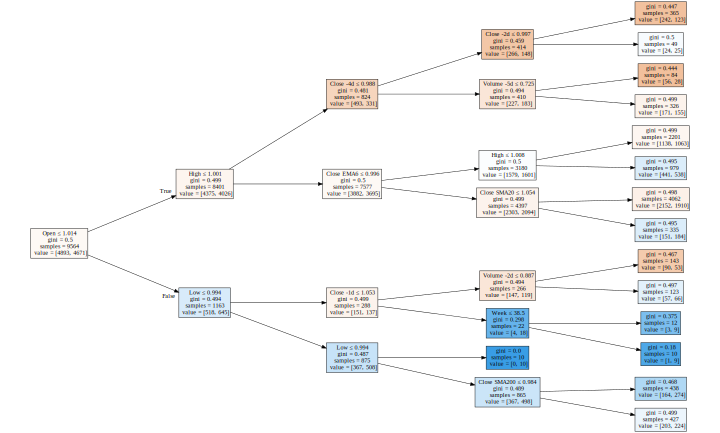

In [43]:
draw_tree(m.estimators_[0], raw_train, precision=3)

In [44]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[1023,  147],
       [1043,  177]], dtype=int64)

## Bagging

In [45]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=20, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.8508992053534086, 0.502928870292887, 0.5274989544123797]


In [46]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[754, 416],
       [772, 448]], dtype=int64)

In [47]:
def plot_metrics(metrics): return metrics.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [48]:
def get_metrics(stamp, y_valid, y_pred, chance) :
    col = ['accuracy', 'precision','recall','f1','chance']
    val = []
    val.append(metrics.accuracy_score(y_valid, y_pred))
    val.append(metrics.precision_score(y_valid, y_pred))
    val.append(metrics.recall_score(y_valid, y_pred))
    val.append(metrics.f1_score(y_valid, y_pred))
    val.append(chance)
    
    return pd.DataFrame(data=[val], columns=col, index=[stamp])

In [49]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
chance = cnf_matrix[1:].sum() / cnf_matrix.sum()

In [50]:
met = get_metrics(STAMP, y_valid, y_pred, chance)

,accuracy,precision,recall,f1,chance
20180314-1549,0.502929,0.518519,0.367213,0.429942,0.51046


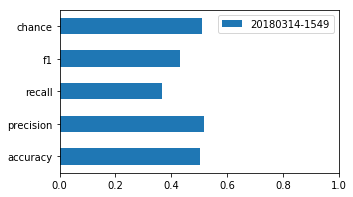

In [51]:
met.T.plot(kind='barh', figsize=(5,3), xlim=(0,1))
met

In [52]:
fi = rf_feat_importance(m, df)

In [53]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

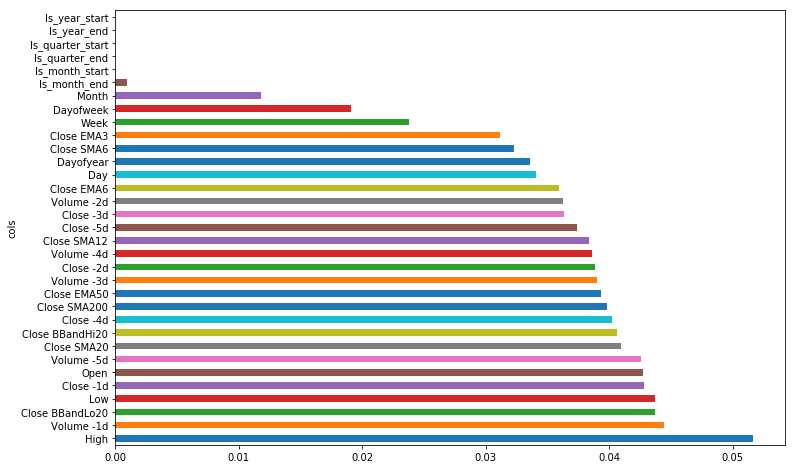

In [54]:
plot_fi(fi)

Some things to try: 
- Add in OHL booleans such as: OpenHigherThanPreviousClose, OpenLowerThanPreviousClose, CloseIsHigh, CloseIsLow, OpenIsHigh, OpenIsLow
- Add in OHL history (-1d, -2d, etc.)
- Add in "Bollinger Band" with +/-1 STD (in addition to standard BBand which is +/-2 STD)